In [1]:
!pip install torch torchvision torchaudio
!pip install gymnasium==0.29.1
!pip install minatar==1.0.15
!pip install matplotlib
!pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.2 MB/s eta 0:00:00


In [2]:
# Imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy
import numpy as np
import pandas as pd
import random
from PIL import Image
import gymnasium as gym
import matplotlib.pyplot as plt
from typing import Callable
from collections import namedtuple
import itertools

In [ ]:
torch.cuda.is_available()

False

**Model**

In [3]:
class DQN(nn.Module):
    def __init__(self, obs_shape: torch.Size, num_actions: int):
        """
        Initialize the DQN network.

        :param obs_shape: Shape of the observation space
        :param num_actions: Number of actions
        """

        # obs_shape is the shape of a single observation -> use this information to define the dimensions of the layers
        super(DQN, self).__init__()

        # TODO: your code
        self.conv1 = nn.Conv2d(obs_shape[-1], 16, stride=1, kernel_size=5)
        self.conv2 = nn.Conv2d(16, 32, stride=1, kernel_size=3)

        self.fc1 = nn.Linear(32 * 4 * 4, 128)
        self.fc2 = nn.Linear(128, num_actions)

        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # TODO: your code
        x = x.permute(0, 3, 1, 2)

        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))

        x = torch.flatten(x, 1) # flatten the intermediate result such that it can serve as input for the first linear layer

        # Final layer consists of 128 "rectifier" units meaning a ReLU activation
        # As several students have not understood it this way, no points are deducted for missing the last activation
        x = self.relu(self.fc1(x))
        out = self.fc2(x)
        return out

In [4]:
def make_epsilon_greedy_policy(Q: nn.Module, num_actions: int):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.

    :param Q: The DQN network.
    :param num_actions: Number of actions in the environment.

    :returns: A function that takes the observation as an argument and returns the greedy action in form of an int.
    """

    def policy_fn(obs: torch.Tensor, epsilon: float = 0.0):
        """This function takes in the observation and returns an action."""
        if np.random.uniform() < epsilon:
            return np.random.randint(0, num_actions)

        # For action selection, we do not need a gradient and so we call ".detach()"
        return Q(obs).argmax().detach().numpy()

    return policy_fn

In [5]:
def linear_epsilon_decay(eps_start: float, eps_end: float, current_timestep: int, duration: int) -> float:
    """
    Linear decay of epsilon.

    :param eps_start: The initial epsilon value.
    :param eps_end: The final epsilon value.
    :param current_timestep: The current timestep.
    :param duration: The duration of the schedule (in timesteps). So when schedule_duration == current_timestep, eps_end should be reached

    :returns: The current epsilon.
    """

    # TODO: your code
    ratio = min(1.0, current_timestep / duration)
    return (eps_start - eps_end) * (1 - ratio) + eps_end

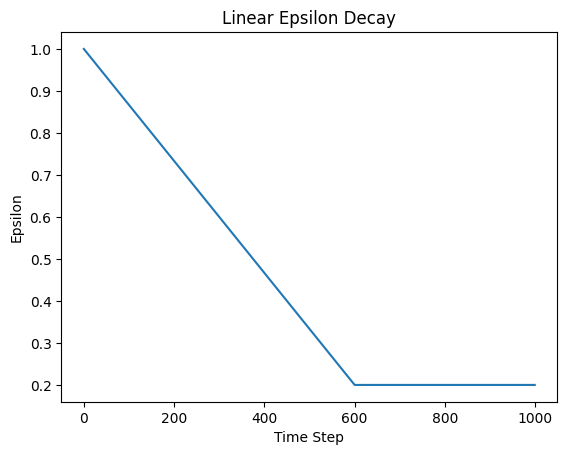

In [6]:
import matplotlib.pyplot as plt

eps_start = 1.0
eps_end = 0.2
schedule_duration = 1000

eps_values = [linear_epsilon_decay(eps_start, eps_end, t, 600) for t in range(schedule_duration)]

plt.plot(range(schedule_duration), eps_values)
plt.xlabel('Time Step')
plt.ylabel('Epsilon')
plt.title('Linear Epsilon Decay')
plt.show()


**Simple ReplayBuffer**

In [7]:
class ReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.data = []
        self.max_size = max_size
        self.position = 0

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        # TODO: Your code
        return len(self.data)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        # TODO: Your code
        if len(self.data) < self.max_size:
            self.data.append((obs, action, reward, next_obs, terminated))
        else:
            self.data[self.position] = (obs, action, reward, next_obs, terminated)
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        # TODO: Your code
        return [torch.stack(b) for b in zip(*random.choices(self.data, k=batch_size))]

**PrioritizedReplayBuffer**

In [8]:
from collections import deque

class PrioritizedReplayBuffer:
    def __init__(self, max_size: int):
        """
        Create the replay buffer.

        :param max_size: Maximum number of transitions in the buffer.
        """
        self.max_size = max_size
        #self.data = deque(maxlen=max_size)
        #self.priorities = deque(maxlen=max_size)
        self.data = []
        self.priorities = []
        self.position = 0
        self.max_priority = 1

    def __len__(self) -> int:
        """Returns how many transitions are currently in the buffer."""
        return len(self.data)

    def get_probabilities(self, alpha):
        # Probability(i) = (priority(i)^alpha)/(Sum(priority(i)^alpha))
        # Priority could have approximation errors, so to address this we use alpha;
        # alpha=0.0 becomes Pure Random sampling
        # alpha=1.0 becomes Pure prioritized random sampling

        priorities_tensor = torch.tensor(self.priorities, dtype=torch.float32)
        scaled_priorities = torch.pow(priorities_tensor, alpha)
        probabilities = scaled_priorities / torch.sum(scaled_priorities)
        return probabilities

    def set_priorities(self, indices, errors, offset=0.05):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset

    def get_importance(self, probabilities, beta):
        # importance_weight = Corrects the bias introduced by not uniformly sampling during the neural network backward pass
        # importance_weight = ((1/N) * (1/Probability(i))) ^ Beta
        # Beta is a hyperparameter here; which similar to alpha, controls how much we want to prioritize

        N_length = len(self.data)
        importance_weight = (1/N_length) * (1/probabilities)
        scaled_importance_weight = torch.pow(importance_weight, beta)
        importance_weight_normalized = scaled_importance_weight / torch.max(scaled_importance_weight)
        max_weight = torch.max(scaled_importance_weight) #To normalize
        return (scaled_importance_weight / max_weight)

    def store(self, obs: torch.Tensor, action: torch.Tensor, reward: torch.Tensor, next_obs: torch.Tensor, terminated: torch.Tensor):
        """
        Adds a new transition to the buffer. When the buffer is full, overwrite the oldest transition.

        :param obs: The current observation.
        :param action: The action.
        :param reward: The reward.
        :param next_obs: The next observation.
        :param terminated: Whether the episode terminated.
        """
        data = (obs, action, reward, next_obs, terminated)
        if len(self.data) < self.max_size:
            self.data.append(data)

            #self.priorities.append(max(self.priorities, default=1))  # Setting initial priorities
            # setting maximum priority in the buffer for new_experiences - generally done by getting max-priority
            # But max(priorities) selection when the buffer gets large becomes computationally complex. So storing
            # with default large max_priority always for the new experience, assuming any priority will not be
            # more than this max_priority
            #self.priorities.append(max(self.priorities, default=1))
            self.priorities.append(self.max_priority)
        else:
            self.data[self.position] = data
            #self.priorities[self.position] = max(self.priorities, default=1)  # Setting max initial priorities
            self.priorities[self.position] = self.max_priority
        self.position = (self.position + 1) % self.max_size

    def sample(self, batch_size: int, alpha=1.0, beta=1.0) -> torch.Tensor:
        """
        Sample a batch of transitions uniformly and with replacement. The respective elements e.g. states, actions, rewards etc. are stacked

        :param batch_size: The batch size.
        :returns: A tuple of tensors (obs_batch, action_batch, reward_batch, next_obs_batch, terminated_batch), where each tensors is stacked.
        """

        sample_size = min(len(self.data), batch_size)
        sample_probs = self.get_probabilities(alpha)
        sample_indices = random.choices(range(len(self.data)), k=batch_size, weights=sample_probs)

        selected_samples = [self.data[i] for i in sample_indices]
        output = [torch.stack(b) for b in zip(*selected_samples)]
        importance = self.get_importance(sample_probs[sample_indices], beta)
        return output, sample_indices, importance

**DQN Update**

In [9]:
def update_dqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()


**DDQN Update**

In [10]:
def update_ddqn(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    # TODO: Calculate the TD-Target
    with torch.no_grad():
        #td_target = rew + gamma * q_target(next_obs).max(dim=1)[0] * (1 - tm.float())
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

    q_val = q(obs).gather(1, act.unsqueeze(1))
    loss = F.mse_loss(q_val, td_target)

    # TODO: Calculate the loss. Hint: Pytorch has the ".gather()" function, which collects values along a specified axis using some specified indexes
    #loss = F.mse_loss(q(obs).gather(1, act.unsqueeze(1)), td_target.unsqueeze(1))

    # TODO: Backpropagate the loss and step the optimizer
    loss.backward()
    optimizer.step()


**DDQN + Prioritized Replay Buffer Update (Importance Sampling)**

In [11]:
def update_ddqn_priority_buffer(
        q: nn.Module,
        q_target: nn.Module,
        optimizer: optim.Optimizer,
        gamma: float,
        obs: torch.Tensor,
        act: torch.Tensor,
        rew: torch.Tensor,
        next_obs: torch.Tensor,
        tm: torch.Tensor,
        importance_weights: torch.Tensor,
    ):
    """
    Update the DQN network for one optimizer step.

    :param q: The DQN network.
    :param q_target: The target DQN network.
    :param optimizer: The optimizer.
    :param gamma: The discount factor.
    :param obs: Batch of current observations.
    :param act: Batch of actions.
    :param rew: Batch of rewards.
    :param next_obs: Batch of next observations.
    :param tm: Batch of termination flags.

    """
    # TODO: Zero out the gradient
    optimizer.zero_grad()

    with torch.no_grad():
        next_q_from_qmodel = q(next_obs)
        next_q_state_from_target = q_target(next_obs)

        max_val = torch.max(next_q_from_qmodel, 1)[1]
        q_val_target = next_q_state_from_target.gather(1, max_val.unsqueeze(1))
        td_target = rew.unsqueeze(1) + gamma * q_val_target * (1 - tm.float().unsqueeze(1))

        # DQN Targets
        #q_val_target = q_target(next_obs).max(dim=1)[0]
        #td_target = rew + gamma * q_val_target * (1 - tm.float())
    q_val = q(obs).gather(1, act.unsqueeze(1))

    mseloss = F.mse_loss(q_val, td_target)
    importance_weights_mean = importance_weights.mean() #torch.FloatTensor(importance_weights).mean()
    weighted_loss = mseloss * importance_weights_mean #Assuming errors for individual samples in loss

    weighted_loss.backward()
    optimizer.step()

    error_batch =  torch.sub(q_val, td_target)
    error_batch = error_batch.detach()

    return error_batch


**DQN Agent**

In [25]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # TODO: Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                # TODO: Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_dqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

**DDQN Agent**

In [26]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDQNAgent:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq

        # TODO: Initialize the Replay Buffer
        self.buffer = ReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0
        epsilon = self.eps_start

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(terminated)
                )

                # TODO: Sample a mini batch from the replay buffer
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = self.buffer.sample(self.batch_size)

                # Update the Q network
                update_ddqn(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch
                )

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

**DDQN + Prioritized Replay Buffer Agent**

In [27]:
EpisodeStats = namedtuple("Stats", ["episode_lengths", "episode_rewards"])


class DDQNAgentPriorityBuffer:
    def __init__(self,
            env,
            gamma=0.99,
            lr=0.001,
            batch_size=64,
            eps_start=1.0,
            eps_end=0.1,
            schedule_duration=10_000,
            update_freq=100,
            maxlen=100_000,
            alpha=1.0,
            beta=1.0,
            buffer_hyperparam_eps_start = 1.0,
            buffer_hyperparam_eps_end = 0.1,
            buffer_hyperparam_decay = 0.0,
        ):
        """
        Initialize the DQN agent.

        :param env: The environment.
        :param gamma: The discount factor.
        :param lr: The learning rate.
        :param batch_size: Mini batch size.
        :param eps_start: The initial epsilon value.
        :param eps_end: The final epsilon value.
        :param schedule_duration: The duration of the schedule (in timesteps).
        :param update_freq: How often to update the Q target.
        :param max_size: Maximum number of transitions in the buffer.
        """

        self.env = env
        self.gamma = gamma
        self.batch_size = batch_size
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.schedule_duration = schedule_duration
        self.update_freq = update_freq
        self.alpha = alpha
        self.beta = beta
        self.buffer_param_start = buffer_hyperparam_eps_start
        self.buffer_param_end = buffer_hyperparam_eps_end
        self.buffer_hyperparam_decay = buffer_hyperparam_decay

        #self.error_to_set_priority = 0.0

        # TODO: Initialize the Prioritized Replay Buffer
        self.buffer = PrioritizedReplayBuffer(maxlen)

        # TODO: Initialize the Deep Q Network. Hint: Remember observation_space and action_space
        self.q = DQN(env.observation_space.shape, env.action_space.n)

        # TODO: Initialize the second Q Network, the target network. Load the parameters of the first one into the second
        self.q_target = DQN(env.observation_space.shape, env.action_space.n)
        self.q_target.load_state_dict(self.q.state_dict())

        # TODO: Create an ADAM optimizer for the Q network
        self.optimizer = optim.Adam(self.q.parameters(), lr=lr)

        self.policy = make_epsilon_greedy_policy(self.q, env.action_space.n)

        # Model trained only for q model (One network), q_target network just do load_state_dict of trained model
        for params in self.q_target.parameters():
            params.requires_grad = False


    def train(self, num_episodes: int) -> EpisodeStats:
        """
        Train the DQN agent.

        :param num_episodes: Number of episodes to train.
        :returns: The episode statistics.
        """
        # Keeps track of useful statistics
        stats = EpisodeStats(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes),
        )
        current_timestep = 0

        epsilon = self.eps_start
        alpha = self.alpha
        beta = self.beta

        for i_episode in range(num_episodes):
            # Print out which episode we're on, useful for debugging.
            if (i_episode + 1) % 10 == 0:
                print(f'Episode {i_episode + 1} of {num_episodes}  Time Step: {current_timestep}  Epsilon: {epsilon:.3f} Alpha: {alpha:.3f} Beta: {beta:.3f}')

            # Reset the environment and get initial observation
            obs, _ = self.env.reset()

            for episode_time in itertools.count():
                #print(f"\n\n LOOP episode_time={episode_time}")

                # TODO: Get current epsilon value
                epsilon = linear_epsilon_decay(self.eps_start, self.eps_end, current_timestep, self.schedule_duration)
                if self.buffer_hyperparam_decay==0.0:
                  alpha = self.alpha
                  beta = self.beta
                else:
                  alpha = linear_epsilon_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)
                  beta = linear_epsilon_decay(self.buffer_param_start, self.buffer_param_end, current_timestep, self.schedule_duration)

                # Choose action and execute
                action = self.policy(torch.as_tensor(obs).unsqueeze(0).float(), epsilon=epsilon)
                next_obs, reward, terminated, truncated, _ = self.env.step(action)

                # Update statistics
                stats.episode_rewards[i_episode] += reward
                stats.episode_lengths[i_episode] += 1

                # TODO: Store sample in the replay buffer
                self.buffer.store(
                    torch.as_tensor(obs, dtype=torch.float32),
                    torch.as_tensor(action),
                    torch.as_tensor(reward, dtype=torch.float32),
                    torch.as_tensor(next_obs, dtype=torch.float32),
                    torch.as_tensor(int(terminated))
                )

                # TODO: Sample a mini batch from the replay buffer
                data, sample_indices, importance = self.buffer.sample(self.batch_size, alpha, beta)
                obs_batch, act_batch, rew_batch, next_obs_batch, tm_batch = data
                #print(f"act_batch={act_batch}")

                # Update the Q network
                batch_errors = update_ddqn_priority_buffer(
                    self.q,
                    self.q_target,
                    self.optimizer,
                    self.gamma,
                    obs_batch.float(),
                    act_batch,
                    rew_batch.float(),
                    next_obs_batch.float(),
                    tm_batch,
                    importance
                )

                # Set prirority of experience based on errors returned from Update step
                self.buffer.set_priorities(sample_indices, batch_errors)

                # Update the current Q target
                if current_timestep % self.update_freq == 0:
                    self.q_target.load_state_dict(self.q.state_dict())
                current_timestep += 1

                #print(f"G-Set next_obs to obs to continue further")
                # Check whether the episode is finished
                if terminated or truncated or episode_time >= 500:
                    break
                obs = next_obs
        return stats

**Create Environment**

In [33]:
# Choose your environment
env = gym.make('MinAtar/SpaceInvaders-v1', render_mode="rgb_array")

# Print observation and action space infos
print(f"Training on {env.spec.id}")
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}\n")

Training on MinAtar/SpaceInvaders-v1
Observation space: Box(False, True, (10, 10, 6), bool)
Action space: Discrete(4)



**Hyperparameters**

In [40]:
"""
# EXP1
# Hyperparameters, Hint: Change as you see fit
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 50_000
UPDATE_FREQ = 100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 100 #1_000
DISCOUNT_FACTOR = 0.99

# Priority Scaling Hyperparameter
ALPHA = 1.0 #0.5
# Importance Sampling weight hyperparameter
BETA = 1.0 #0.5
# Try Decaying Hyperparamteres of Prioritizied Replay Buffer, since we need higher values during start of training and it learns
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1
"""

"""
#EXP2
LR = 0.001
BATCH_SIZE = 8
REPLAY_BUFFER_SIZE = 50_000
UPDATE_FREQ = 10 #100
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 100 #1_000
DISCOUNT_FACTOR = 0.99

ALPHA = 1.0 #0.5
BETA = 1.0 #0.5
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1
"""

#EXP3
LR = 0.001
BATCH_SIZE = 16
REPLAY_BUFFER_SIZE = 50_000
UPDATE_FREQ = 50
EPS_START = 0.5
EPS_END = 0.05
SCHEDULE_DURATION = 15_000
NUM_EPISODES = 200 #1_000
DISCOUNT_FACTOR = 0.99

ALPHA = 1.0 #0.5
BETA = 1.0 #0.5
ALPHA_BETA_EPS_START = 1.0
ALPHA_BETA_EPS_END = 0.1

**Initialise Agents**

In [41]:
# Train DQN
dqn_agent = DQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)

# Train DDQN
ddqn_agent = DDQNAgent(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
)

# Train DDQN + Priority Replay Buffer + constant alpha beta
ddqn_priority_agent = DDQNAgentPriorityBuffer(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
    buffer_hyperparam_eps_start = ALPHA_BETA_EPS_START,
    buffer_hyperparam_eps_end = ALPHA_BETA_EPS_END,
    buffer_hyperparam_decay = 0.0
)

# Train DDQN + Priority Replay Buffer + with alpha,beta decay
ddqn_priority_decay_agent = DDQNAgentPriorityBuffer(
    env,
    gamma=DISCOUNT_FACTOR,
    lr=LR,
    batch_size=BATCH_SIZE,
    eps_start=EPS_START,
    eps_end=EPS_END,
    schedule_duration=SCHEDULE_DURATION,
    update_freq=UPDATE_FREQ,
    maxlen=REPLAY_BUFFER_SIZE,
    alpha=ALPHA,
    beta=BETA,
    buffer_hyperparam_eps_start = ALPHA_BETA_EPS_START,
    buffer_hyperparam_eps_end = ALPHA_BETA_EPS_END,
    buffer_hyperparam_decay = 1.0
)



In [42]:
print(f"\n Training DQN for num_episodes={NUM_EPISODES}")
dqn_stats = dqn_agent.train(NUM_EPISODES)

print(f"\n Training DDQN for num_episodes={NUM_EPISODES}")
ddqn_stats = ddqn_agent.train(NUM_EPISODES)

print(f"\n Training DDQN + priority-replay + constant alpha beta; for num_episodes={NUM_EPISODES}")
ddqn_prioritybuf_stats = ddqn_priority_agent.train(NUM_EPISODES)

print(f"\n Training DDQN + priority-replay + alpha beta decay; for num_episodes={NUM_EPISODES}")
ddqn_prioritybuf_decay_stats = ddqn_priority_decay_agent.train(NUM_EPISODES)


 Training DQN for num_episodes=200
Episode 10 of 200  Time Step: 360  Epsilon: 0.489
Episode 20 of 200  Time Step: 1005  Epsilon: 0.470
Episode 30 of 200  Time Step: 1390  Epsilon: 0.458
Episode 40 of 200  Time Step: 2361  Epsilon: 0.429
Episode 50 of 200  Time Step: 3098  Epsilon: 0.407
Episode 60 of 200  Time Step: 4318  Epsilon: 0.370
Episode 70 of 200  Time Step: 5312  Epsilon: 0.341
Episode 80 of 200  Time Step: 6429  Epsilon: 0.307
Episode 90 of 200  Time Step: 7580  Epsilon: 0.273
Episode 100 of 200  Time Step: 9155  Epsilon: 0.225
Episode 110 of 200  Time Step: 10288  Epsilon: 0.191
Episode 120 of 200  Time Step: 12054  Epsilon: 0.138
Episode 130 of 200  Time Step: 14147  Epsilon: 0.076
Episode 140 of 200  Time Step: 16454  Epsilon: 0.050
Episode 150 of 200  Time Step: 18861  Epsilon: 0.050
Episode 160 of 200  Time Step: 21062  Epsilon: 0.050
Episode 170 of 200  Time Step: 23621  Epsilon: 0.050
Episode 180 of 200  Time Step: 25570  Epsilon: 0.050
Episode 190 of 200  Time Step:

# 1.5 Results

Like in the last exercise, we will look at the resulting episode reward.

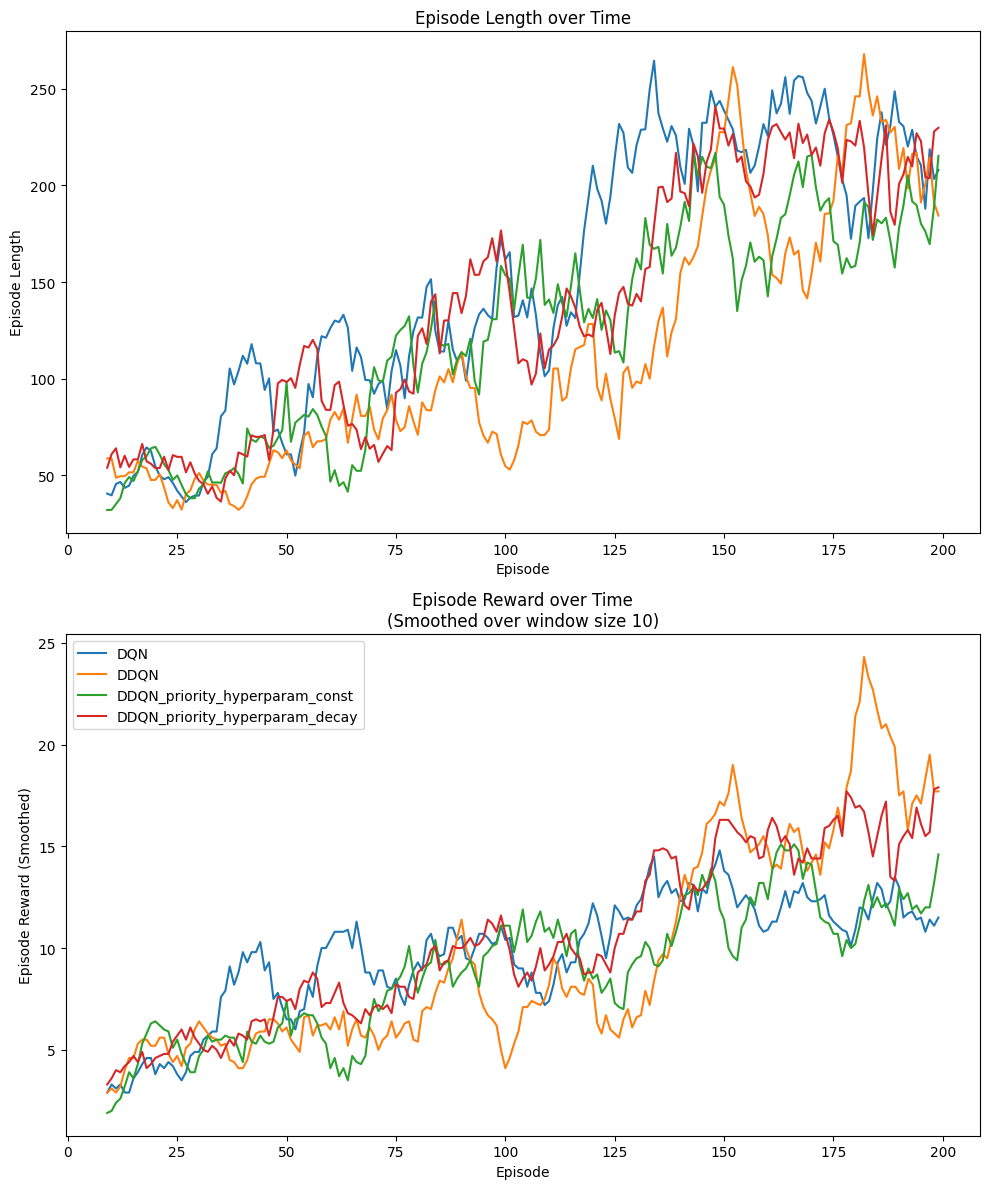

In [43]:
smoothing_window=10
fig, axes = plt.subplots(2, 1, figsize=(10, 12), tight_layout=True)

# Plot the episode length over time
ep_dqn = pd.Series(dqn_stats.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ep_ddqn = pd.Series(ddqn_stats.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ep_ddqn_priority_const = pd.Series(ddqn_prioritybuf_stats.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()
ep_ddqn_priority_decay = pd.Series(ddqn_prioritybuf_decay_stats.episode_lengths).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax = axes[0]
ax.plot(ep_dqn, label="DQN")
ax.plot(ep_ddqn, label="DDQN")
ax.plot(ep_ddqn_priority_const, label="DDQN_priority_hyperparam_const")
ax.plot(ep_ddqn_priority_decay, label="DDQN_priority_hyperparam_decay")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Length")
ax.set_title("Episode Length over Time")

# Plot the episode reward over time
ax = axes[1]
rew_dqn = pd.Series(dqn_stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rew_ddqn = pd.Series(ddqn_stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rew_ddqn_priority_const = pd.Series(ddqn_prioritybuf_stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
rew_ddqn_priority_decay = pd.Series(ddqn_prioritybuf_decay_stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()

ax.plot(rew_dqn, label="DQN")
ax.plot(rew_ddqn, label="DDQN")
ax.plot(rew_ddqn_priority_const, label="DDQN_priority_hyperparam_const")
ax.plot(rew_ddqn_priority_decay, label="DDQN_priority_hyperparam_decay")

ax.set_xlabel("Episode")
ax.set_ylabel("Episode Reward (Smoothed)")
ax.set_title(f"Episode Reward over Time\n(Smoothed over window size {smoothing_window})")

plt.legend()
plt.show()

Lastly, let us see what the learned policy does in action.

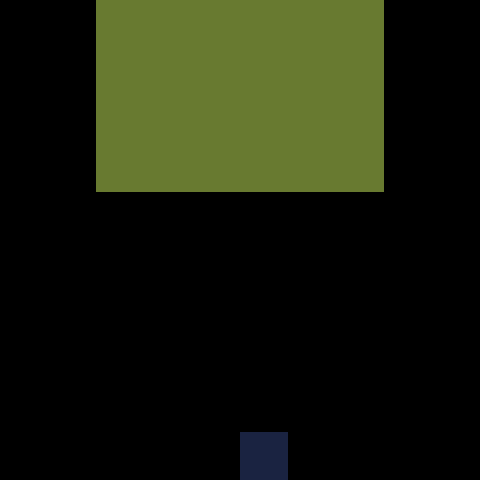

In [ ]:
from IPython.display import Image as IImage

def save_rgb_animation(rgb_arrays, filename, duration=50):
    """Save an animated GIF from a list of RGB arrays."""
    # Create a list to hold each frame
    frames = []

    # Convert RGB arrays to PIL Image objects
    for rgb_array in rgb_arrays:
        rgb_array = (rgb_array*255).astype(np.uint8)
        rgb_array = rgb_array.repeat(48, axis=0).repeat(48, axis=1)
        img = Image.fromarray(rgb_array)
        frames.append(img)

    # Save the frames as an animated GIF
    frames[0].save(filename, save_all=True, append_images=frames[1:], duration=duration, loop=0)

def rendered_rollout(policy, env, max_steps=1_000):
    """Rollout for one episode while saving all rendered images."""
    obs, _ = env.reset()
    imgs = [env.render()]

    for _ in range(max_steps):
        action = policy(torch.as_tensor(obs, dtype=torch.float32).unsqueeze(0))
        obs, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())

        if terminated or truncated:
            break

    return imgs

policy = make_epsilon_greedy_policy(agent.q, num_actions=env.action_space.n)
imgs = rendered_rollout(policy, env)
save_rgb_animation(imgs, "trained.gif")
IImage(filename="trained.gif")